### A/B тестирование

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**ОПИСАНИЕ ЗАДАЧИ**

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

    Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
    Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.

Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 
    Контрольной (группе А) доступен первый вариант рекомендаций.
    Тестовой (группе B) доступен второй вариант. 

Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:
- выборка имеет достаточный для принятия решения объём;
- выбран достаточный интервал времени для тестирования;
- группы максимально сбалансированы;
- внешнее вмешательство минимально.

In [53]:
# прочитаем результаты тестирования
ab_data = pd.read_csv('data/ab_data.csv')

# И выведем пять первых строк таблицы:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [54]:
# Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [55]:
# переведем столбец с информацией о дате события (timestamp) в формат datetime.
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [56]:
# Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно 
# сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, 
# и суммарное количество совершённых целевых действий. 
# Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() 
# и переименуем столбец user_id в users_count с помощью метода rename().

daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

###  Задание 4.1
Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [57]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
round(daily_data[(daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')]['conversion'],2)

6    12.32
Name: conversion, dtype: float64

In [58]:
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


### Визуальный анализ конверсии в группах

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

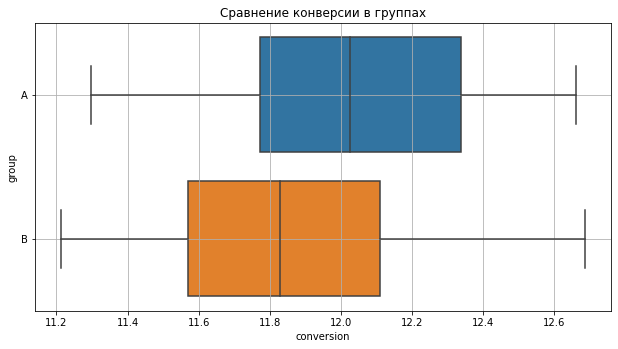

In [59]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

### Примечание. 
Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

In [60]:
# Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):
conversion_piv = daily_data.groupby('group')['conversion'].agg(['mean', 'median'])
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Тут нам помогут кумулятивные метрики.

### Кумулятивные метрики
Это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

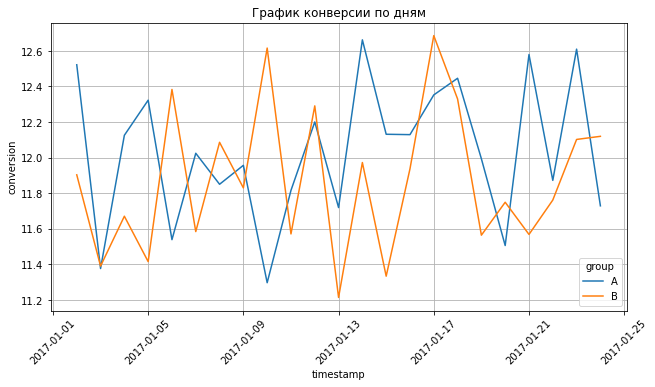

In [61]:
# осмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. 
# Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, 
# а по оси ординат — показатель конверсии

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

In [62]:
# Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, 
# в который запишем результат работы метода cumsum() по столбцу users_count.

# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

/Users/a.y.macbookair/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [63]:
# Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: 
# сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков 
# количества посетителей (users_count) и количества совершённых целевых действий (converted).
# После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества 
# посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


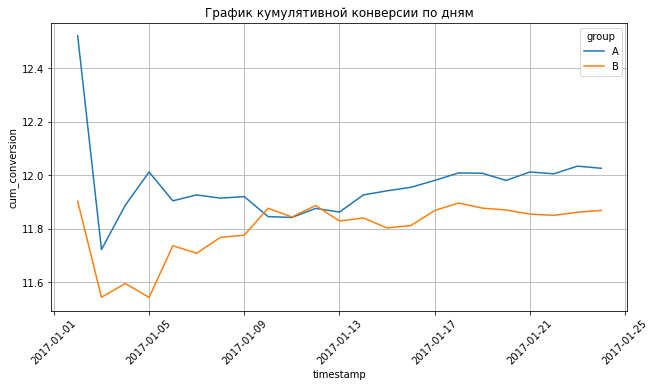

In [64]:
# построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

### Вводные данные для задач 4.6–4.9
Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

In [65]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

###  Задание 4.6
Постройте таблицу со следующими ежедневными показателями:

- количество посетителей сайта;
- суммарное число транзакций;
- общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.
Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [66]:
# переведем столбец с информацией о дате события в формат datetime
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

In [84]:
# Объединим таблицы
sample_ab = sample_a.merge(sample_b,how = 'outer')

In [86]:
sample_ab

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A
...,...,...,...,...,...
122949,2020-11-23,9.965675e+08,0,0,B
122950,2020-11-23,9.970803e+07,0,0,B
122951,2020-11-23,9.984814e+08,0,0,B
122952,2020-11-23,9.991118e+08,0,0,B


In [96]:
# сагрегируем данные по посетителям и числу транзакций
daily_sample_ab = sample_ab.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'cust_count'})
daily_sample_ab.head()

,date,group,cust_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [106]:
# количество посетителей сайта, число транзакций, сумма покупок в группе А на 8 ноября 2020 года
daily_sample_ab[(daily_sample_ab['date'] == '2020-11-08') & (daily_sample_ab['group'] == 'A')]

,date,group,cust_count,transactions,revenue
4,2020-11-08,A,3354,25,846051


###  Задание 4.7
Добавьте в каждую из таблиц кумулятивные метрики:

- кумулятивное количество посетителей сайта;
- кумулятивное суммарное число транзакций;
- кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [108]:
# вычисляем кумулятивную сумму количества посетителей
daily_sample_ab['cum_cust_count'] = daily_sample_ab.groupby(['group'])['cust_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых транзакций
daily_sample_ab['cum_transactions'] = daily_sample_ab.groupby(['group'])['transactions'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_sample_ab['cum_revenue'] = daily_sample_ab.groupby(['group'])['revenue'].cumsum()
# вычисляем кумулятивную конверсию (по количеству транзакций)
daily_sample_ab['cum_conversion'] = daily_sample_ab['cum_transactions']/daily_sample_ab['cum_cust_count'] * 100
# вычисляем кумулятивный средний чек
daily_sample_ab['cum_avg_bill'] = daily_sample_ab['cum_revenue']/daily_sample_ab['cum_transactions'] * 100

In [110]:
daily_sample_ab.tail(2)

,date,group,cust_count,transactions,revenue,cum_cust_count,cum_transactions,cum_revenue,cum_conversion,cum_avg_bill
34,2020-11-23,A,3458,26,858274,61571,441,25909066,0.716246,5.875072e+06
35,2020-11-23,B,3493,30,1585306,61383,463,32454342,0.754281,7.009577e+06


### Задание 4.8
Постройте графики кумулятивной конверсии в каждой группе

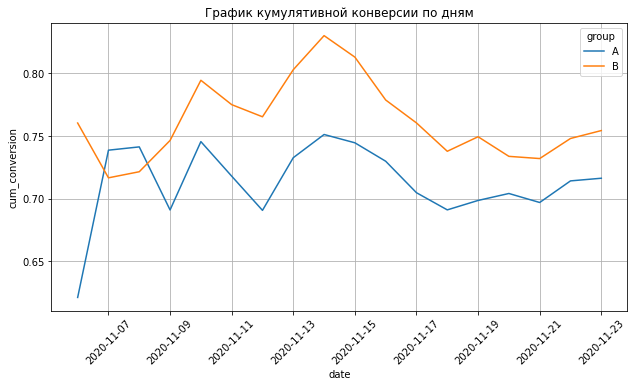

In [111]:
# построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_ab, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

 Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде. 

### Задание 4.9
Постройте графики кумулятивного среднего чека в каждой группе

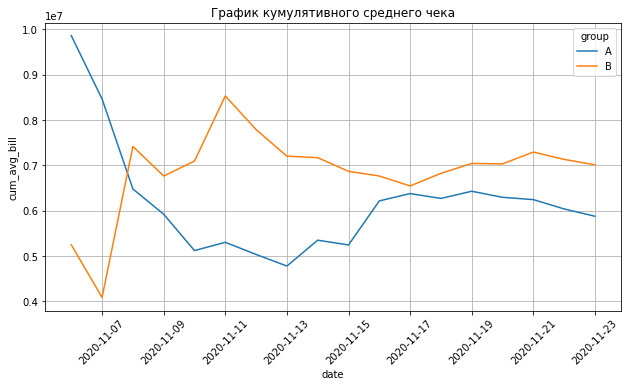

In [112]:
# построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_avg_bill', data=daily_sample_ab, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат. 

### Статистический тест для конверсии

In [113]:
# Импортируем функцию proportions_ztest() из модуля statsmodels:
from statsmodels.stats.proportion import proportions_ztest

In [114]:
# сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) 
# и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count'])
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Нулевая гипотеза:
H0: конверсии в группах А и B равны.

Альтернативная гипотеза:
H1: (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза): конверсия в группе А выше, чем конверсия в группе B.

In [116]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


P-value (0.1) больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 


На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

- отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
- попытаться усовершенствовать модель и провести тестирование снова;
- использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.


Стараются придерживаться уровней значимости или . Помним, что больший уровень значимости подразумевает больший риск совершить ошибку I рода (отклонить верную нулевую гипотезу).

Вы сами определяете уровень значимости в зависимости от вашей гипотезы и того, сколько будет стоить вам ошибка I рода.
Как правило, если возникают спорные ситуации, то склоняются в пользу уже существующего варианта А, так как он не требует временных и денежных затрат на внедрение.

В нашем примере варианты А и B оказались равными по признаку конверсии при уровне значимости , однако при уровне значимости вариант А оказывается более эффективным.

Так или иначе, немедленное внедрение варианта B — определённо не лучшая идея. Либо его необходимо доработать и провести тестирование заново, либо стоит отказаться от него вовсе.

### Статистические тесты для проверки других метрик

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [117]:
# Прочитаем результаты теста:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


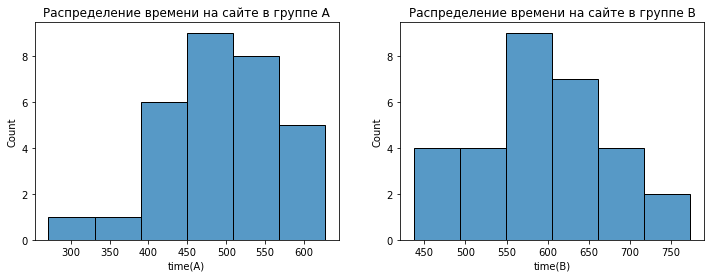

In [118]:
# Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [119]:
# Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих 
# распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [120]:
# распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, 
# чтобы сравнить среднее время посещения сайта в группах.

# Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, 
# что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' 
# (правосторонняя — 'greater’).

from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


В результате проведения T-теста мы получили p-value 0 (<0.05), а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: среднее время, проводимое на сайте, в группе А меньше, чем в группе B.

Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая. 

### Задание 5.2
Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. 
Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите 0.1.

In [122]:
# Импортируем функцию proportions_ztest() из модуля statsmodels:
from statsmodels.stats.proportion import proportions_ztest

# сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) 
# и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.
transactions_piv= sample_ab.groupby('group')['transactions'].agg(
    ['sum', 'count'])
display(transactions_piv)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=transactions_piv['sum'], #число "успехов"
    nobs=transactions_piv['count'], #общее число наблюдений
    alternative='smaller',)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,441,61571
B,463,61383


p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


### Задание 5.3
Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите 0.1

In [126]:
# Добавим поле с ежедневным средним чеком
daily_sample_ab['daily_bill'] = daily_sample_ab['revenue'] / daily_sample_ab['transactions']

# Проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_sample_ab[daily_sample_ab['group'] == 'A']['daily_bill'])
shapiro_result_b = shapiro(daily_sample_ab[daily_sample_ab['group'] == 'B']['daily_bill'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


### Задание 5.4
Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите 0.1.

In [128]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаковый'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.1 #уровень значимости
#вычисляем результат теста для выборок
results = mannwhitneyu(
    daily_sample_ab[daily_sample_ab['group'] == 'A']['daily_bill'],
    daily_sample_ab[daily_sample_ab['group'] == 'B']['daily_bill'], 
    alternative='less')
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.09
Отвергаем нулевую гипотезу. Средний чек в группах одинаковый
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


### Доверительный интервал для среднего при известном стандартном отклонении

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

In [130]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [132]:
# По специфическим причинам реализации функция возвращает не совсем z-критическое, 
# а его отрицательный модуль, поэтому мы берём его со знаком минус.

from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

In [133]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (12180, 20020)


Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

###  Задание 6.5
Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [140]:
from scipy.stats import norm

n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = -norm.ppf(alpha/2) # z критическое - можно таже рассчитать в специальном калькуляторе

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound,2), round(upper_bound,2)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
print('z_crit:', round(z_crit,2))

Доверительный интервал: (11.86, 12.84)
z_crit: 1.64


### Доверительный интервал для среднего при НЕизвестном стандартном отклонении

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

In [141]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [143]:
# Аналогично z-критическому функция t.ppf возвращает отрицательный модуль t-критического, 
# поэтому мы берём его со знаком минус:

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [144]:
# Теперь составим доверительный интервал для истинного среднего. Вычислим левую и нижнюю границу по формуле. 
# Округлим результат и выведем на экран:

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


**Примечание**. 

Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:
- Выборка должна быть случайной.
- Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

### Задание 6.6
Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [145]:
from scipy.stats import t

n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


### Доверительный интервал для пропорции

In [146]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [147]:
# Для удобства создадим отдельные таблицы для каждой из групп пользователей:

#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

In [148]:
# Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). 
# У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности 
# (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, 
# умноженных на 100 % и округлённых до второго знака после запятой.

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [149]:
# Теперь применим нашу функцию к данным группы А и группы B:

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86 % до 12.19 %, а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.

Что значит такое пересечение интервалов для нас? Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Можно даже рассчитать эту вероятность, но лучше пойти другим путём.

Лучше построить доверительный интервал разницы пропорций (конверсий).

In [151]:
# Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки 
# для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — 
# уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ 
# доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [152]:
# Вызовем функцию и построим интересующий нас доверительный интервал:

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

### Задание 6.9
Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

Давайте поможем менеджеру ответить на несколько вопросов!

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.

In [160]:
# Воспользуемся сформированной ранее функцией и построим доверительный интервал:

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# применим нашу функцию к данным группы А и группы B:

conf_interval_a = proportions_conf_interval(
n=189, # размер выборки
x_p=132/n, # выборочная пропорция
gamma = 0.9) # надежность

print('Доверительный интервал: {}'.format(conf_interval_a))


Доверительный интервал: (64.35, 75.33)


### Задание 6.10
Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

Группа А (Персональные скидки):
- Число добавленных в корзину товаров - 45
- Размер выборки - 1000

Группа B (Хиты продаж):
- Число добавленных в корзину товаров - 50
- Размер выборки - 1000

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [161]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# Вызовем функцию и построим интересующий нас доверительный интервал:

# размеры выборок групп А и B
n = [1000, 1000]
# выборочная пропорция групп A и B
xp = [45/n[0], 50/n[1]]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

# Доверительный интервал для разности конверсий: (-1.36, 2.36)
# Вывод: арианты А и B равнозначны по показателю конверсии верно 

Доверительный интервал для разности конверсий: (-1.36, 2.36)
